## Predicting Password Strength
The goal of this project is it to build a system that can reliably classify a passwort either as weak, medium or strong. For that we use the following dataset: https://www.kaggle.com/datasets/bhavikbb/password-strength-classifier-dataset

## The Data
### Analysing And Cleaning The Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Read the dataset into a pandas DataFrame
df = pd.read_csv("data.csv", on_bad_lines='skip')

# Display the first few rows of the DataFrame
print(df.head())
print('Shape: ', df.shape)


      password  strength
0     kzde5577         1
1     kino3434         1
2    visi7k1yr         1
3     megzy123         1
4  lamborghin1         1
Shape:  (669640, 2)


[0.1339555582103817, 0.7418926587420106, 0.12415178304760767]


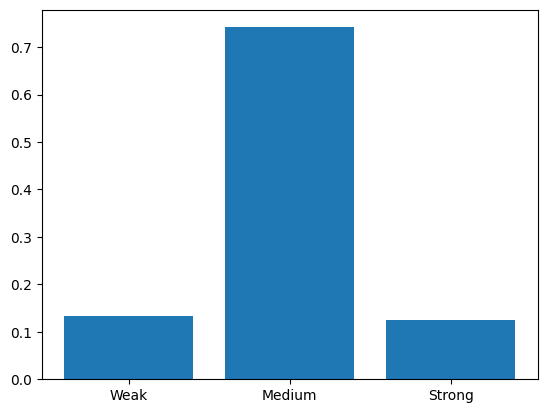

In [ ]:
sample_distribution = [df['strength'].value_counts()[i] / df.shape[0] for i in range(3)]
print(sample_distribution)
# plot the distribution
plt.bar(['Weak', 'Medium', 'Strong'], sample_distribution)
plt.show()

In [ ]:
# delete duplicates and null values
print('Number of duplicates: ', df.duplicated(['password']).sum())
print('Number of null values:\n', df.isnull().sum())
df.dropna(inplace=True)
print(df.shape)

Number of duplicates:  0
Number of null values:
 password    1
strength    0
dtype: int64
(669639, 2)


## Extracting Features
The following features are extracted:
- `int` length
- `bool` does it contain digits
- `bool` does it contain special charachters
- `bool` does it contain upper case characters
- `bool` does it contain lower case characters
- `float` the Shannon Entropy of the password
- `bool` does it contain a substring that is common (e.g. '1234')

In [ ]:
import math
from collections import Counter

# extract the features into individual columns
df['nchars'] = df['password'].apply(lambda x: len(x))
df['digits'] = df['password'].apply(lambda x: any(c.isdigit() for c in x))
df['uppercase'] = df['password'].apply(lambda x: any(c.isupper() for c in x))
df['lowercase'] = df['password'].apply(lambda x: any(c.islower() for c in x))
df['special'] = df['password'].apply(lambda x: any(not c.isalnum() for c in x))

# calculate the probability of each character in the all passwords string
all_passwords = ''.join(df['password'])
counter = Counter(all_passwords)
char_probabilities = {char: count / len(all_passwords) for char, count in counter.items()}
# calculate Shannon Entropy
df['entropy'] = df['password'].apply(lambda x: -sum(char_probabilities[c] * math.log2(char_probabilities[c]) for c in x))

Extract the common strings presence feature

In [ ]:
from operator import contains
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(analyzer='char', ngram_range=(4, 6), min_df=.002, lowercase=False, token_pattern=None)
count_paras = vectorizer.fit_transform(df['password']).toarray()


# print some examples of common substrings
common_ngrams = vectorizer.get_feature_names_out()
print("Common substrings: ", common_ngrams)
# display passwords that contain one of these substrings
contains_common = df['password'][count_paras.sum(axis=1) > 0]
print("Passwords that contain one of these substrings:\n", contains_common)
print("Percentage of passwords containing one of these substrings:\n", (contains_common.shape[0] / df.shape[0]))

# add coulumn
df['ngrams'] = df['password'].apply(lambda x: any(ngram in x for ngram in common_ngrams))

Common substrings:  ['1234' '12345' '123456' '1987' '1991' '1992' '1994' '1995' '2008' '2009'
 '2010' '2011' '2012' '2013' '2345' '23456' '234567' '3456' '34567' '4567'
 '5678' 'a123' 'a201' 'an12' 'e123' 'er12' 'i123' 'juan' 'love' 'mari'
 'n123' 'o123' 'r123' 's123' 'ster' 'y123']
Passwords that contain one of these substrings:
 3                          megzy123
25                      cigicigi123
34                        memjan123
36                       exitos2009
84                        yllime123
                    ...            
669605                   skyline123
669609                    piecia123
669611                   lmfao12345
669618    juanpaganini588@gmail.com
669628                    mario3391
Name: password, Length: 54866, dtype: object
Percentage of passwords containing one of these substrings:
 0.08193369860477064


### Normalize the features


In [ ]:
print(df.head())
# normalize
df['entropy'] = (df['entropy'] - df['entropy'].min()) / (df['entropy'].max() - df['entropy'].min())
df['nchars'] = (df['nchars'] - df['nchars'].min()) / (df['nchars'].max() - df['nchars'].min())
# convert to float from bool
df['digits'] = df['digits'].astype(float)
df['uppercase'] = df['uppercase'].astype(float)
df['lowercase'] = df['lowercase'].astype(float)
df['special'] = df['special'].astype(float)
df['ngrams'] = df['ngrams'].astype(float)
print(df.head())

      password  strength  nchars  digits  uppercase  lowercase  special  \
0     kzde5577         1       8    True      False       True    False   
1     kino3434         1       8    True      False       True    False   
2    visi7k1yr         1       9    True      False       True    False   
3     megzy123         1       8    True      False       True    False   
4  lamborghin1         1      11    True      False       True    False   

    entropy  ngrams  
0  1.019103   False  
1  1.211728   False  
2  1.319889   False  
3  1.215133    True  
4  1.711075   False  
      password  strength    nchars  digits  uppercase  lowercase  special  \
0     kzde5577         1  0.031963     1.0        0.0        1.0      0.0   
1     kino3434         1  0.031963     1.0        0.0        1.0      0.0   
2    visi7k1yr         1  0.036530     1.0        0.0        1.0      0.0   
3     megzy123         1  0.031963     1.0        0.0        1.0      0.0   
4  lamborghin1         1  0.0456

In [ ]:
y = df['strength']
X = df.drop(['password', 'strength'], axis=1)

## Analyzing The Features

### Correlation between features:

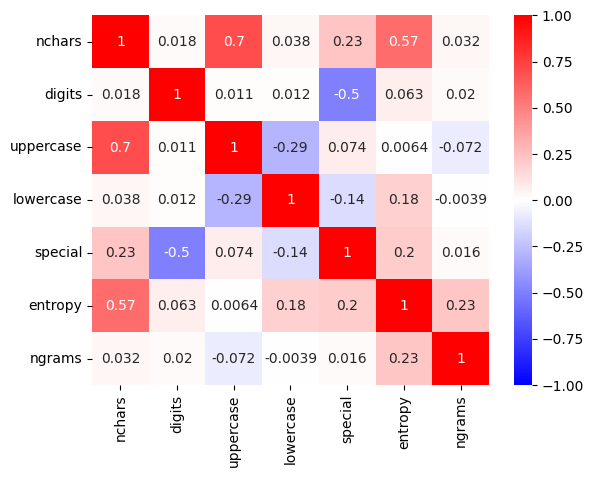

In [ ]:
import seaborn as sns

sns.heatmap(X.corr(), vmin=-1, vmax=1, annot=True, cmap='bwr')
plt.show()

In [ ]:
# Get the correlation between the features and y
corr = X.corrwith(y)
print(corr)


nchars       0.836817
digits       0.039434
uppercase    0.662505
lowercase    0.039179
special      0.178645
entropy      0.418399
ngrams       0.023248
dtype: float64


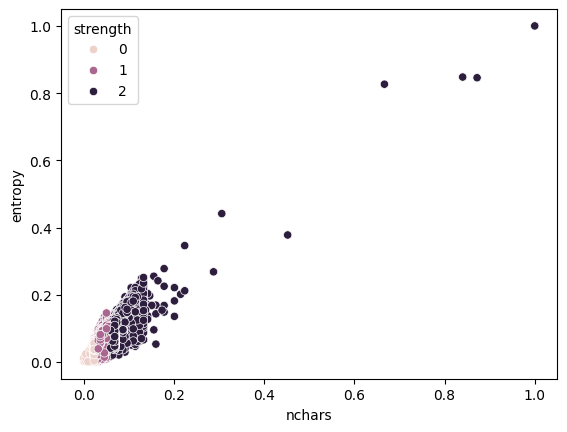

In [ ]:
# plot correlation between password length and its entrophy (non boolean values)
sns.scatterplot(x=X['nchars'], y=X['entropy'], hue=y)
plt.show()

Getting the normalized probability distribtuion of P(strenght|ngram), in order to judge the significance of this feature.

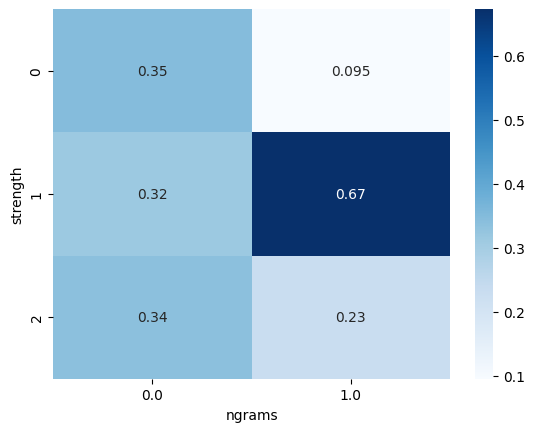

In [ ]:
all_samples = pd.concat([X, y], axis=1)
pivot_table = all_samples.pivot_table(index='strength', columns='ngrams', aggfunc='size', fill_value=0)
pivot_table = pivot_table.div(sample_distribution, axis=0)
pivot_table = pivot_table.div(pivot_table.sum(axis=0), axis=1)

# Plot the heatmap
sns.heatmap(pivot_table, annot=True, cmap='Blues')
plt.show()

The probability distribution shows that if ngrams == False we can not deduct any information about the strength. If on the other hand ngrams == True the data suggest that the password is of medium or even strong strength. This is counterintuitive and the opposite of what we hoped for. So probably the feature does not contain the hoped for information and it is best to drop it.

In [ ]:
X = X.drop('ngrams', axis=1)

Also we can drop the feature lowercase since it has a low covariance with y and most passwords contain lowercase letters anyways.

In [ ]:
X = X.drop('lowercase', axis=1)

# Split The Data

In [ ]:
from sklearn.model_selection import train_test_split
# train, validation, test 80%:10%:10%
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)
X_val, X_test, y_val, y_test = train_test_split(X_eval, y_eval, test_size=0.5, random_state=42, shuffle=True)
print(len(y_train), len(y_val), len(y_test))

535711 66964 66964




1.   **Original** dataset after splitting and normalization







In [ ]:
X_train_org = X_train.copy()
X_val_org = X_val.copy()
X_test_org = X_test.copy()


2.   **Merge** of the two features: digits and special since they have a high
covariance with each other but alone both of them have a low covariance with the strength.

In [ ]:
X_train['digits_special'] = X_train['digits'] * X_train['special']
X_val['digits_special'] = X_val['digits'] * X_val['special']
X_test['digits_special'] = X_test['digits'] * X_test['special']

X_train_merge = X_train.drop(['digits', 'special'], axis=1)
X_val_merge = X_val.drop(['digits', 'special'], axis=1)
X_test_merge = X_test.drop(['digits', 'special'], axis=1)



3.   We will also test reduced version of dataset, containing only entrophy of the password and information if it contains a special character or digits.


In [ ]:
X_train_red = X_train_merge.drop(['uppercase'], axis=1)
X_val_red = X_val_merge.drop(['uppercase'], axis=1)
X_test_red = X_test_merge.drop(['uppercase'], axis=1)
X_train_red = X_train_red.drop(['nchars'], axis=1)
X_val_red = X_val_red.drop(['nchars'], axis=1)
X_test_red = X_test_red.drop(['nchars'], axis=1)
X_train_red.head()


,entropy,digits_special
652002,0.025194,0.0
626295,0.087810,0.0
64216,0.063253,0.0
424195,0.071291,0.0
275731,0.066972,0.0


**Training**
We trained all three models and evaluated them on validation dataset to see which one performs the best.

In [ ]:
from sklearn.linear_model import LogisticRegression
model_1 = LogisticRegression(max_iter=1000)
model_1.fit(X_train_org, y_train)

y_pred_org = model_1.predict(X_val_org)
accuracy = (y_pred_org == y_val).sum() / len(y_val)
print("Model 1  Validation accuracy:", accuracy)

model_2 = LogisticRegression(max_iter=1000)
model_2.fit(X_train_merge, y_train)

y_pred_merge = model_2.predict(X_val_merge)
accuracy = (y_pred_merge == y_val).sum() / len(y_val)
print("Model 2  Validation accuracy:", accuracy)

model_3 = LogisticRegression(max_iter=1000)
model_3.fit(X_train_red, y_train)

y_pred_red= model_3.predict(X_val_red)
accuracy = (y_pred_red == y_val).sum() / len(y_val)
print("Model 3  Validation accuracy:", accuracy)

Model 1  Validation accuracy: 0.9549310077056329
Model 2  Validation accuracy: 0.9548712741174362
Model 3  Validation accuracy: 0.7989964757182964


Cross validation to measure the consistency of the best performing model.

In [ ]:
from sklearn.model_selection import cross_val_score

# Perform 5-fold cross-validation
cv_scores = cross_val_score(model_1, X_train_org, y_train, cv=5)

# Print the cross-validation scores
print("Cross-Validation Scores: ", cv_scores)
print("Mean CV Score: ", cv_scores.mean())
print("Standard Deviation of CV Score: ", cv_scores.std())

Cross-Validation Scores:  [0.94873207 0.94992627 0.95003827 0.94973026 0.95026227]
Mean CV Score:  0.949737826936088
Standard Deviation of CV Score:  0.0005314922890053113


**Final evaluation**

We choose the model that performed best on validation set as our final model.


In [ ]:
# final test on test set
y_pred = model_1.predict(X_test_org)
print(len(X_test_org))
accuracy = (y_pred == y_test).sum() / len(y_test)
print("Final accuracy:", accuracy)

66964
Final accuracy: 0.9557374111462875


After creating confusion matrix we could see where the model made mistakes most often.

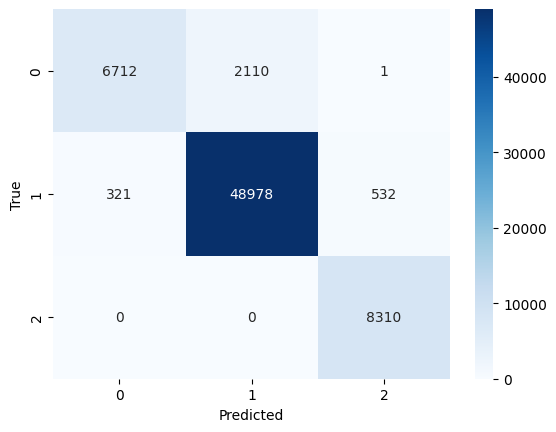

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Further analysis of wrong classifications. We wanted to see what was the probability of class when it was a wrong classification and how "sure" the model was on the right classifications.

        probability  real  predicted
22570      0.550057     1          0
246006     0.551522     0          1
112775     0.750984     0          1
249110     0.507886     0          1
403065     0.516088     0          1
...             ...   ...        ...
602787     0.644734     0          1
367586     0.512640     1          0
157118     0.633303     0          1
177637     0.584817     0          1
558939     0.623706     0          1

[2964 rows x 3 columns]
Average probability of predicted class 0.9084610075626182
Average probability of predicted class in wrong classificaton 0.6209822922896376


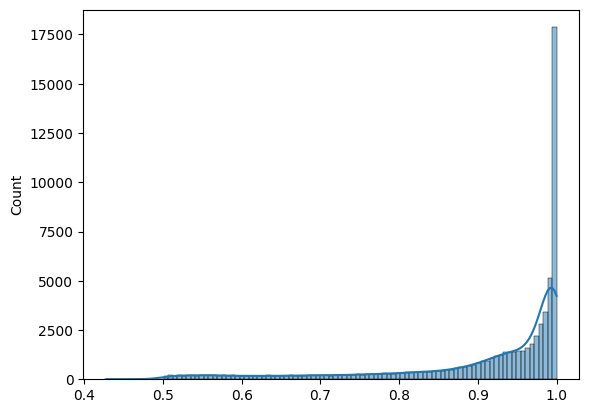

In [ ]:
# check what was the probability of each class for wrongly classified examples
probs = model_1.predict_proba(X_test_org)
prob = probs.max(axis=1)
new_df = pd.DataFrame({'probability': prob, 'real': y_test, 'predicted': y_pred })
# print only ones where predicted != real
print(new_df[new_df['predicted'] != new_df['real']])
# print the average of a probability of predicted class when classification was wrong
print("Average probability of predicted class",prob.mean())
print("Average probability of predicted class in wrong classificaton",new_df[new_df['predicted'] != new_df['real']]['probability'].mean())
# visualize probabilities
sns.histplot(prob, kde=True)
plt.show()




Roc curves of each class.

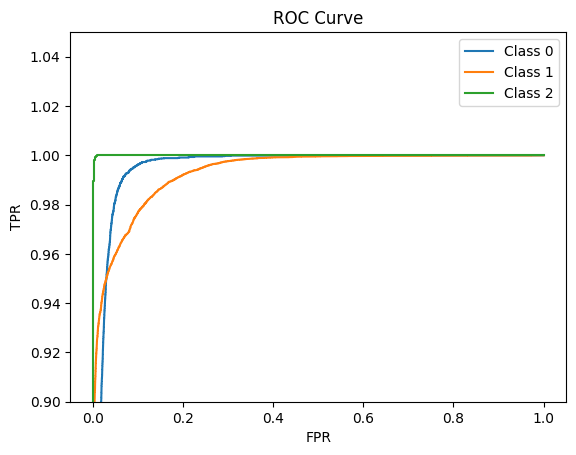

In [ ]:
# create roc curves for all three classes
from sklearn.metrics import roc_curve
for i in range(3):
    y_test_bin = (y_test == i).astype(int)
    fpr, tpr, thresholds = roc_curve(y_test_bin, probs[:, i])
    plt.plot(fpr, tpr, label='Class {}'.format(i))
    plt.ylim([0.9, 1.05])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve')
    plt.legend()
